In [2]:
from matplotlib import pyplot as plt
from kats.consts import TimeSeriesData
import pandas as pd
from utils import save_fig_for_raport, dataframe_to_latex_tabular 
from pandas.plotting import autocorrelation_plot
import pandas.plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.detectors.seasonality import FFTDetector
from kats.detectors.outlier import OutlierDetector

In [3]:
cat_id_list = [
  # Dataset 1
         2,
         6,
         9,
         10,
         11,
         13,
         20,
         22,
         24,
         26,
         27,
         28,
         29,
         32,
         33,
         34,
         39,
         41,
         51,
         54,
      # Dataset 2
        12532,
        11694,
        11716,
        11950,
        11195,
        11998,
        274,
        11407,
        46,
        11326,
        11335,
        12197,
        11693,
        11780,
        12502,
        11866,
        11400,
        12256,
        10320,
        10030,
        # Seasonal dataset
        12322,
        11428,
        11850,
        11852,
        273,
        11036,
        11213,

        16,
        17,
        28,
        34,
        40,
        44,
        45,
        48,
        77,
        79,
        11217,
        11334,
        11992,
        12265,
        12511,
        10053,
        11037,
        11041,
        11048,
        11456,
        11817,
        13323,
]

In [4]:
raw_data = pd.read_csv('../datasets/raw/market_insights_overview_all_2022_04_26.csv', parse_dates=["date"])

# Filter away early 2018 data as it seems to contain errors
#raw_data =raw_data .loc[raw_data ['date'] > '2018-12-01']

In [5]:
print(raw_data.count())
data_filtered_cats = raw_data.loc[raw_data['cat_id'].isin(cat_id_list)]
print(data_filtered_cats.count())
data_filtered_cats.head()
data_filtered_cats.to_csv("../datasets/raw/market_insights_overview_all_2022_04_26_filtered.csv", index=False)

id                 41941504
product_id         41941504
manufacturer_id    41941504
cat_id             41941504
root_cat_id        41941504
date               41941504
hits               41941504
clicks             41941504
last_modified      41941504
dtype: int64
id                 7883054
product_id         7883054
manufacturer_id    7883054
cat_id             7883054
root_cat_id        7883054
date               7883054
hits               7883054
clicks             7883054
last_modified      7883054
dtype: int64


,hits,date
788,17,2019-09-16
1292,12,2019-09-16
1316,11,2019-09-16
1777,9,2019-09-16
1904,8,2019-09-16
...,...,...
39630616,1,2022-02-13
39631104,1,2022-02-13
39631695,1,2022-02-13
39632754,1,2022-02-13


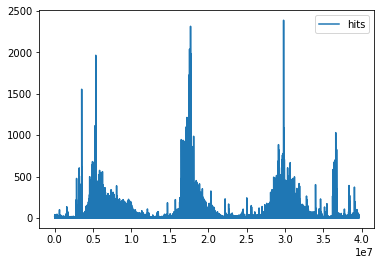

In [5]:
raw_data.loc[raw_data["cat_id"] == 11037][["hits"]].plot()
raw_data.loc[raw_data["cat_id"] == 11037][["hits", "date"]]

In [6]:
categories = pd.read_csv("../datasets/raw/solr_categories_all_2022_02_14.csv")
# Join market_insight table with category names
category_names = categories[[ "internal_doc_id", "title"]]
category_id_to_names_map = dict(map(lambda x: (x["internal_doc_id"], x["title"]), category_names.to_dict("records")))
category_name_to_id_map = dict(map(lambda x: (x["title"], x["internal_doc_id"]), category_names.to_dict("records")))

In [7]:

data_grouped = raw_data.groupby(['cat_id', "date"], as_index=False).sum()
data_grouped["date"] = pd.to_datetime(data_grouped["date"])
data_grouped["interest"] = data_grouped["hits"] + data_grouped["clicks"]

# Join with category names
data_grouped = pd.merge(data_grouped , category_names, how="left", left_on=["cat_id"], right_on=["internal_doc_id"])
data_grouped.rename(columns={"title": "cat_name"}, inplace=True)
data_grouped.drop(columns=["internal_doc_id"], inplace=True, axis=1)

data_chosen_categories = data_grouped[["interest", "date", "cat_id", "cat_name"]]
data = data_chosen_categories

<AxesSubplot:>

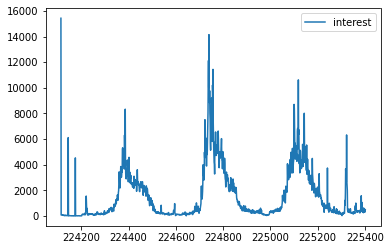

In [8]:
data.loc[data["cat_id"] == 11037][["interest"]].plot()

In [9]:
# Fill in all missing days
#data_grouped_filled_dates = data_chosen_categories.groupby(pd.Grouper(key="date", freq='D')).sum()

#data = data_grouped_filled_dates
#data.head()

In [10]:
# Pivot table by cat_id
data_by_cat_id = data.pivot(index=["date"], columns=["cat_id", "cat_name"])["interest"]
data_by_cat_id.head()

cat_id,2,5,6,9,10,11,13,14,15,16,...,13770,13771,13772,13773,13774,13775,13776,13778,13779,13789
cat_name,Bærbar PC,Prosessor (CPU),Digitalkamera,Harddisk og SSD,Hovedkort,PC-høyttaler,Kabinett,Kontrollerkort,Minnekortleser,Diverse lydkort,...,Knivblokk,Fuglemat og meiseboller,Karabinkrok,Bål og opptenning,Fotobakgrunn,Sveisemaske og sveisehjelm,Vernehjelm,Barneservise,Sterilisator og rengjøring,Utebukse til barn
date,,,,,,,,,,,,,,,,,,,,,
2018-08-01,155160.0,14884.0,9733.0,22866.0,10190.0,2425.0,8731.0,215.0,216.0,346.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-02,870.0,44.0,56.0,161.0,53.0,12.0,53.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-03,992.0,36.0,56.0,152.0,46.0,7.0,65.0,NaN,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-04,865.0,39.0,68.0,134.0,73.0,5.0,52.0,2.0,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-05,800.0,44.0,74.0,113.0,49.0,10.0,48.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
corr_categories = [2, 6, 9, 10, 11, 13, 20]

seasonal_categories_cat_name =["Vinterjakke",
"Vintersko",
"Langrennski",
"Skisko",
"Varmeovn",
"Snøfreser",
"Snøskuffe",]

seasonal_categories = list(map(lambda x: category_name_to_id_map[x], seasonal_categories_cat_name))
seasonal_categories

[12322, 11428, 11850, 11852, 273, 11036, 11213]

## Decompose time series
We can decompose each series in into its trend, seasonality and residuals (rest).
Then we can use the dicky-fuller test on the residuals to check if the series is stationary.
If the p-value is < 0.05 it is stationary.
Results: The risiduals are mostly stationary

In [12]:
nettverkskabler = data_grouped.loc[data["cat_id"] ==  11037]
#nettverkskabler['date'] =  pd.to_datetime(raw_data['date'])
nettverkskabler = nettverkskabler.rename(columns={"date": "time"})
ts = TimeSeriesData(nettverkskabler[["time", "interest"]])

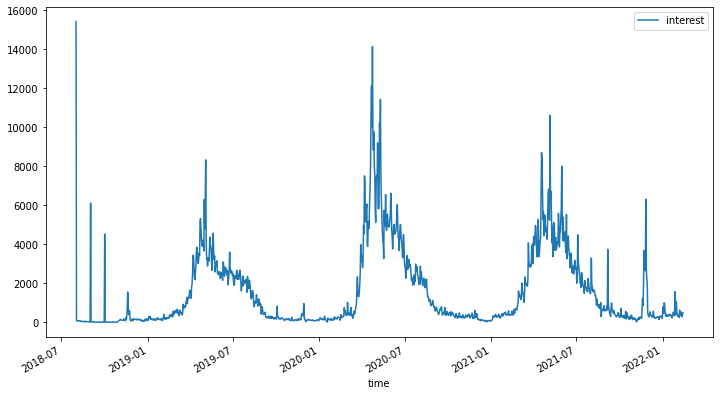

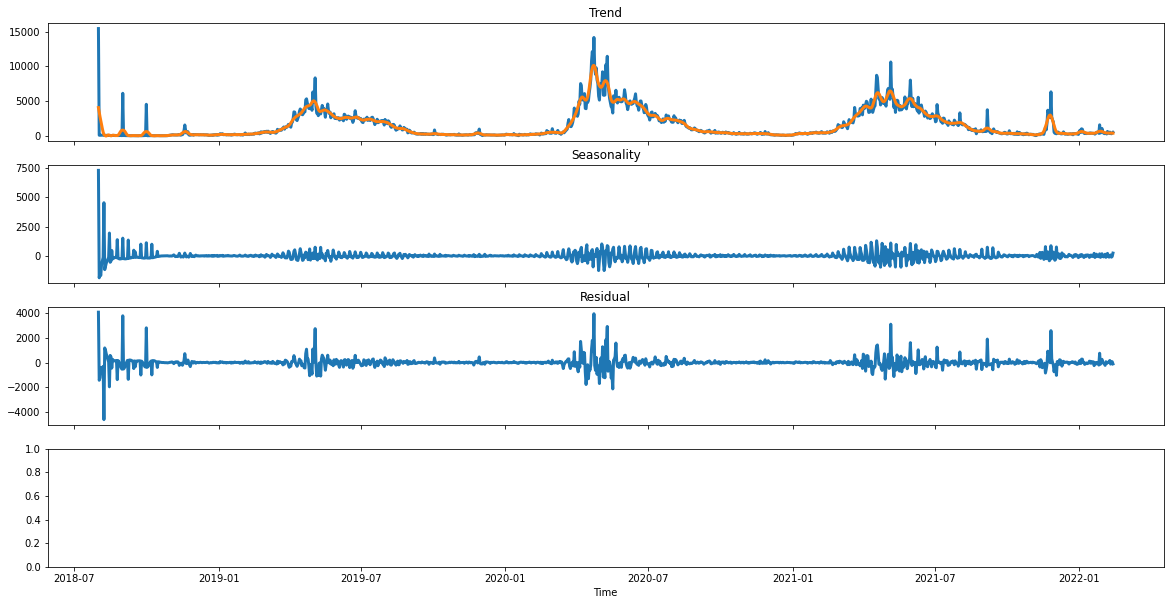

In [13]:
ts.plot()
decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

In [14]:
# Detect seasonality
fft_detector = FFTDetector(ts)
fft_detector.detector()

{'seasonality_presence': True,
 'seasonalities': [322.0, 184.0, 117.09090909090911]}

In [15]:
outlier_detector = OutlierDetector(ts, "additive")

outlier_detector.detector()
outliers = outlier_detector.outliers
outliers[0]

[Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-08-02 00:00:00'),
 Timestamp('2018-08-03 00:00:00'),
 Timestamp('2018-08-04 00:00:00'),
 Timestamp('2018-08-29 00:00:00'),
 Timestamp('2018-08-30 00:00:00'),
 Timestamp('2018-08-31 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-09-02 00:00:00'),
 Timestamp('2018-09-03 00:00:00'),
 Timestamp('2018-09-04 00:00:00'),
 Timestamp('2018-09-28 00:00:00'),
 Timestamp('2018-09-29 00:00:00'),
 Timestamp('2018-09-30 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-10-02 00:00:00'),
 Timestamp('2018-10-03 00:00:00'),
 Timestamp('2018-10-04 00:00:00'),
 Timestamp('2018-11-19 00:00:00'),
 Timestamp('2019-04-07 00:00:00'),
 Timestamp('2019-04-08 00:00:00'),
 Timestamp('2019-04-11 00:00:00'),
 Timestamp('2019-04-14 00:00:00'),
 Timestamp('2019-04-15 00:00:00'),
 Timestamp('2019-04-21 00:00:00'),
 Timestamp('2019-04-22 00:00:00'),
 Timestamp('2019-04-23 00:00:00'),
 Timestamp('2019-04-30 00:00:00'),
 Timestamp('2019-05-

<AxesSubplot:xlabel='time'>

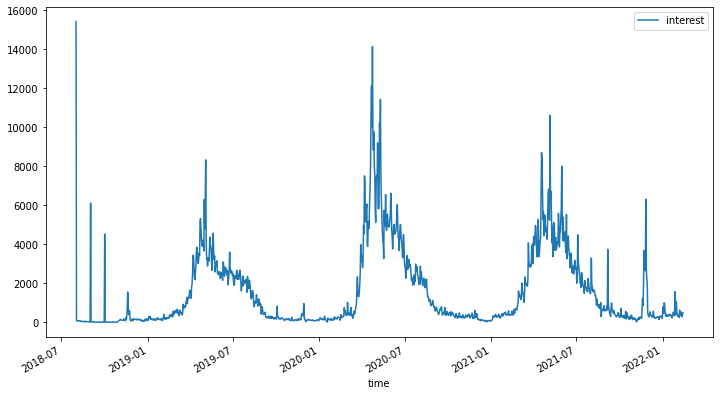

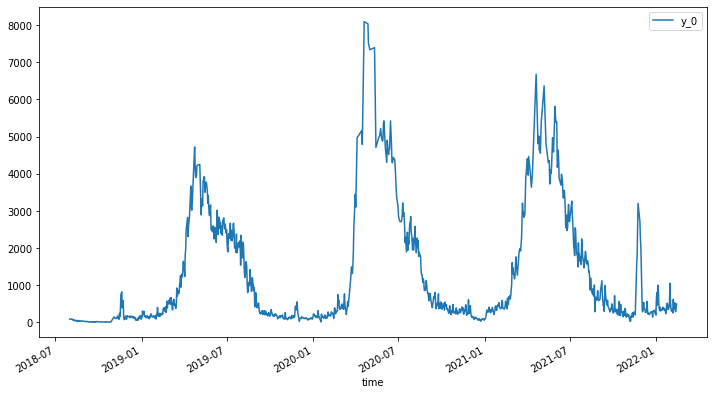

In [16]:
ts_outliers_interpolated = outlier_detector.remover(interpolate=True)
ts.plot()
ts_outliers_interpolated.plot()

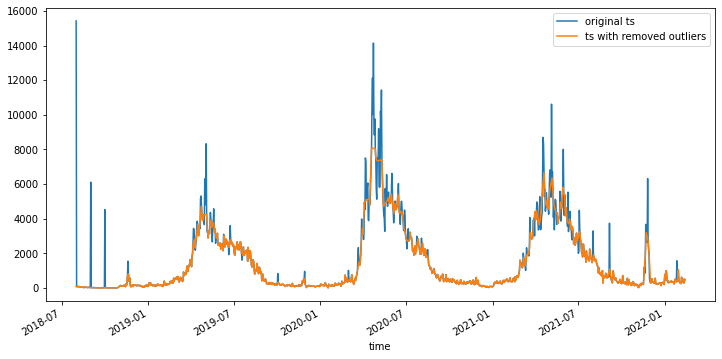

In [17]:
ax = ts.to_dataframe().plot(x="time", y="interest", figsize=(12, 6))
ts_outliers_interpolated.to_dataframe().plot(x="time", y="y_0", ax=ax)
plt.legend(labels=["original ts", "ts with removed outliers"])
plt.show()

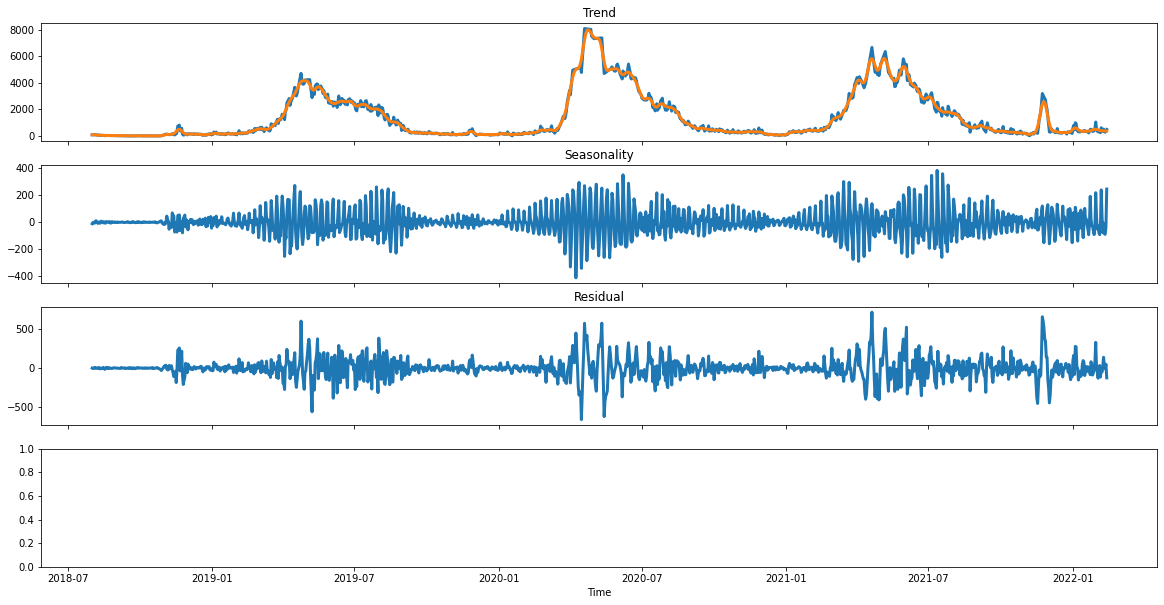

In [18]:

decomposer = TimeSeriesDecomposition(ts_outliers_interpolated, decomposition="additive")
results_outliers = decomposer.decomposer()
fig = decomposer.plot()

In [19]:
(results_outliers["seasonal"].to_dataframe()["season"] + results_outliers["seasonal"].to_dataframe()["season"])
results_outliers["rem"]

,time,resid
0,2018-08-01,-0.363701
1,2018-08-02,-5.850475
2,2018-08-03,0.942150
3,2018-08-04,7.968736
4,2018-08-05,-3.555832
...,...,...
1288,2022-02-09,139.755844
1289,2022-02-10,31.854421
1290,2022-02-11,-8.896340
1291,2022-02-12,49.339339
